# Controlling an interferometer using EPICS and a stage using ophyd
awojdyla@lbl.gov, Feb 2026

In [11]:
# !pip install pyepics
# !pip install ophyd

In [12]:
#using base 3.13.5 on GW
import epics
import ophyd

## Reading the PV for the interferometer
We assume that an IOC is running for the Smaract interferomter, and that we can poll it through the network

In [10]:
epics.caget('CATERETE:PICOSCALE:POS_0')

-1883860998

In [33]:
from time import sleep
from matplotlib import pyplot as plt
import numpy as np  

p = epics.PV('CATERETE:PICOSCALE:POS_0')

N_buffer = 100
pos0_pm = np.zeros(N_buffer)
t_s = np.zeros(N_buffer)
for i in range(N_buffer):
# Get the value and metadata in a dictionary
    pvdata = p.get_with_metadata()
    pos0_pm[i] = pvdata['value']
    t_s[i] = pvdata['timestamp']
    sleep(0.1)



Text(0, 0.5, 'Position (nm)')

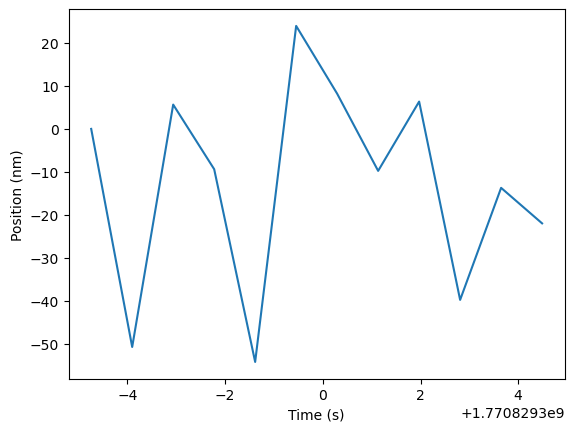

In [34]:
plt.plot(t_s,(pos0_pm-pos0_pm[0])*1e-3)
plt.xlabel('Time (s)')
plt.ylabel('Position (nm)')

## Moving the stage

### using the python package

In [2]:
#!pip install newportxps

In [5]:
from newportxps import NewportXPS

STAGE_NAME = 'Group1.Pos'
IP_ADDRESS = '192.168.10.20'
USERNAME = 'Administrator'
PASSWORD = 'Administrator'

# Connect to the controller (replace with your controller's IP or hostname)
xps = NewportXPS(IP_ADDRESS, username=USERNAME, password=PASSWORD)
# Get a status report
status = xps.status_report()
#print(status)

# XPS host:         192.168.10.20 (XPS-0E7C)
# Firmware:         XPS-RL-D-N16001
# Current Time:     Wed Feb 11 09:14:48 2026
# Last Reboot:      Sat Dec  6 11:52:05 2025
# Trajectory Group: None
# Groups and Stages
Group1 (singleaxisinuse), Status: Ready state from motion
# Group1.Pos (XM@XML210@XPS-DRV11)
      Hardware Status: First driver powered on - ZM low level
      Positioner Errors: OK
Group2 (singleaxisinuse), Status: Ready state from motion
# Group2.Pos (MLT@MLT50@XPS-DRV11)
      Hardware Status: First driver powered on - ZM low level
      Positioner Errors: OK


In [6]:
xps.read_stage_position(STAGE_NAME)


10.999999

In [7]:
xps.move_stage(STAGE_NAME, 10)

''

### create an ophyd wrapper

In [15]:
from ophyd import Device, Component as Cpt, EpicsMotor
from ophyd import Signal

class NewportXPSStage(Device):
    """Ophyd wrapper for Newport XPS stage"""
    
    # Create a soft positioner that wraps the XPS stage
    position1 = Cpt(Signal, value=0, kind='hinted')
    setpoint = Cpt(Signal, value=0, kind='normal')
    
    def __init__(self, xps_controller, stage_name, *args, **kwargs):
        self.xps = xps_controller
        self.stage_name = stage_name
        super().__init__(*args, **kwargs)
        # Initialize position from hardware
        self.position1.put(self.xps.read_stage_position(self.stage_name))
    
    def set(self, position):
        """Move stage to position"""
        self.xps.move_stage(self.stage_name, position)
        self.position1.put(position)
        self.setpoint.put(position)
        return self.position1
    
    def read(self):
        """Read current position"""
        pos = self.xps.read_stage_position(self.stage_name)
        self.position1.put(pos)
        return self.position1.read()
    
    def get(self):
        """Get current position value"""
        return self.xps.read_stage_position(self.stage_name)

# Create the ophyd stage object
stage = NewportXPSStage(xps, STAGE_NAME, name='newport_stage')

In [18]:
#just works
stage.set(10)  # Move to position 10

Signal(name='newport_stage_position1', parent='newport_stage', value=10, timestamp=1770830566.5346797)

### using ophyd async